# Bayesian Optimization with Learned Linear Calibration

In [1]:
import time

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# fix random seeds
rng_seed = 0
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

from custom_mean import LinearCalibration

## Definition of Objective

In [2]:
# load Xopt vocs
vocs = VOCS.from_yaml(open("vocs.yaml").read())
print(vocs.as_yaml())

variables:
  distgen:r_dist:sigma_xy:value: [0.21021247820852546, 0.4999996083265339]
  distgen:t_dist:length:value: [3.000000758511308, 11.998569812014836]
  SOL1:solenoid_field_scale: [0.19409053333889578, 0.2563030896232562]
  CQ01:b1_gradient: [-0.009999618141995313, 0.0099925212795954]
  SQ01:b1_gradient: [-0.009999490058927914, 0.009999443099573097]
  L0A_phase:dtheta0_deg: [-24.998714513984325, 9.991752397382681]
  L0B_phase:dtheta0_deg: [-24.99972566363747, 9.998904767155892]
  QA01:b1_gradient: [1.000039854940649, 3.998197816908352]
  QA02:b1_gradient: [-3.990444304119449, -1.0105116218007806]
  QE01:b1_gradient: [1.0007061999094193, 6.9997773994714345]
  QE02:b1_gradient: [-6.999887318319171, 0.9983521010385275]
  QE03:b1_gradient: [-6.998418428856965, 0.9993010487139868]
  QE04:b1_gradient: [1.000026533968218, 6.998086093251312]
constraints: {}
objectives: {sigma_xy: MINIMIZE}
constants: {'distgen:total_charge:value': 250.0, 'L0A_scale:voltage': 58000000.0,
  'L0B_scale:volt

In [3]:
# load NN prior model
input_transformer = torch.load("model/input_transformer.pt")
output_transformer = torch.load("model/output_transformer.pt")
input_variables, output_variables = variables_from_yaml(open("model/variables.yml"))
lume_model = PyTorchModel(
    model_file="model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_transformer],
    output_transformers=[output_transformer],
)
# wrap in lume module
lume_module = LUMEModule(
    model=lume_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs,
)

In [4]:
# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2) * 1e3  # in mm

    def forward(self, x):
        idx_sigma_x = self.model.output_order.index("sigma_x")
        idx_sigma_y = self.model.output_order.index("sigma_y")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

In [5]:
# Xopt evaluator function
def evaluate(input_dict):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["sigma_x"], model_result["sigma_y"])
    return {vocs.objective_names[0]: sigma_xy.detach().item()}

In [6]:
# define miscalibrated objective model
mismatch_scale = 0.3
x_dim = len(lume_module.feature_order)
y_dim = len(vocs.objective_names)
x_shift = mismatch_scale * torch.rand(x_dim)
x_scale = torch.ones(x_dim) + mismatch_scale * torch.rand(x_dim)
y_shift = mismatch_scale * torch.rand(y_dim)
y_scale = torch.ones(y_dim) + mismatch_scale * torch.rand(y_dim)

miscalibrated_objective_model = LinearCalibration(
    model=objective_model,
    x_shift_fixed=x_shift,
    x_scale_fixed=x_scale,
    y_shift_fixed=y_shift,
    y_scale_fixed=y_scale,
)

## Definition of Custom Mean and Xopt

In [7]:
# define custom mean
custom_mean = LinearCalibration(
    model=miscalibrated_objective_model,
    x_dim=x_dim,
    y_dim=y_dim,
)

In [8]:
# Xopt definition
model_constructor = StandardModelConstructor(
    mean_modules={vocs.objective_names[0]: custom_mean},
    trainable_mean_keys=[vocs.objective_names[0]],
)
numerical_optimizer = LBFGSOptimizer(n_restarts=5, n_raw_samples=20)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
    numerical_optimizer=numerical_optimizer,
)
evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)

In [9]:
# create initial samples
n_init = 3
X.random_evaluate(n_samples=n_init)

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,sigma_xy,xopt_runtime,xopt_error
1,0.340961,7.095401,0.229080,0.002327,-0.001361,6.943058,-17.235516,1.602194,-1.362961,1.332641,-1.117627,-3.546874,3.326699,250.0,58000000.0,70000000.0,1.098742,0.001299,False
2,0.292747,8.186283,0.200824,-0.005836,-0.008512,9.284301,-20.450329,2.614610,-2.917433,3.869172,-5.194154,0.849025,3.297679,250.0,58000000.0,70000000.0,1.699734,0.000482,False
3,0.325327,6.186447,0.196351,-0.000581,0.008579,-19.142005,-24.251397,1.658048,-1.437695,4.512191,-2.650047,-3.940374,1.337429,250.0,58000000.0,70000000.0,1.954004,0.000379,False


## Bayesian Optimization

In [10]:
%%time
n_step = 50
for _ in range(n_step):
    X.step()

CPU times: user 8min 47s, sys: 46.8 s, total: 9min 34s
Wall time: 8min 12s


## Display Results

In [11]:
# print data set
X.data

,distgen:r_dist:sigma_xy:value,distgen:t_dist:length:value,SOL1:solenoid_field_scale,CQ01:b1_gradient,SQ01:b1_gradient,L0A_phase:dtheta0_deg,L0B_phase:dtheta0_deg,QA01:b1_gradient,QA02:b1_gradient,QE01:b1_gradient,QE02:b1_gradient,QE03:b1_gradient,QE04:b1_gradient,distgen:total_charge:value,L0A_scale:voltage,L0B_scale:voltage,sigma_xy,xopt_runtime,xopt_error
1,0.340961,7.095401,0.229080,0.002327,-0.001361,6.943058,-17.235516,1.602194,-1.362961,1.332641,-1.117627,-3.546874,3.326699,250.0,58000000.0,70000000.0,1.098742,0.001299,False
2,0.292747,8.186283,0.200824,-0.005836,-0.008512,9.284301,-20.450329,2.614610,-2.917433,3.869172,-5.194154,0.849025,3.297679,250.0,58000000.0,70000000.0,1.699734,0.000482,False
3,0.325327,6.186447,0.196351,-0.000581,0.008579,-19.142005,-24.251397,1.658048,-1.437695,4.512191,-2.650047,-3.940374,1.337429,250.0,58000000.0,70000000.0,1.954004,0.000379,False
4,0.500000,7.815559,0.225991,0.009992,-0.009784,-12.667957,-19.914856,2.391698,-3.390904,5.619293,-5.790347,-4.145997,4.384580,250.0,58000000.0,70000000.0,0.572972,0.000578,False
5,0.348520,11.104445,0.245664,0.009993,0.009576,1.916822,-17.885877,1.942334,-2.045016,1.534121,-3.995824,-2.938047,4.979090,250.0,58000000.0,70000000.0,1.063485,0.000619,False
6,0.500000,6.253935,0.219350,0.009993,-0.003012,-12.618895,-22.408884,2.647466,-3.078406,6.551459,-3.141977,-2.231210,4.941945,250.0,58000000.0,70000000.0,2.401966,0.000603,False
7,0.354146,9.686293,0.231706,0.009993,0.008861,-5.353206,-11.084284,2.308733,-2.351271,2.672511,-1.901857,-5.130653,5.341412,250.0,58000000.0,70000000.0,0.327784,0.000707,False
8,0.261922,9.340907,0.238909,0.002454,0.009999,-14.330300,-15.788261,1.809456,-1.962114,1.559965,-3.941729,-2.227077,4.060953,250.0,58000000.0,70000000.0,1.478331,0.000628,False
9,0.253869,9.368951,0.235744,0.007335,0.001718,8.300052,-21.627737,2.807656,-1.424844,3.081237,-0.909741,-5.636252,5.264394,250.0,58000000.0,70000000.0,0.956098,0.000628,False
10,0.396128,6.032571,0.195137,0.007023,0.005638,-2.221583,-13.045798,2.923235,-2.742553,6.823201,-6.071879,-2.575528,5.485196,250.0,58000000.0,70000000.0,0.574302,0.000636,False


In [12]:
# predict optimum
x_optimum = X.generator.get_optimum()
y_optimum = pd.DataFrame(evaluate(x_optimum.to_dict("index")[0]), index=[0])
y_optimum

,sigma_xy
0,0.696447


In [13]:
# calculate running minimum
running_min = []
for i in range(len(X.data)):
    running_min.append(X.data[vocs.objective_names[0]].iloc[:i+1].min())

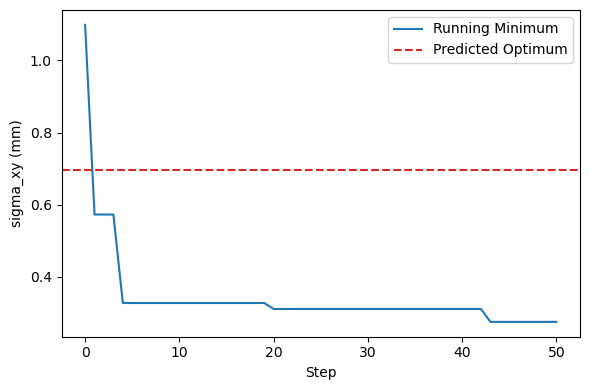

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x = torch.arange(n_step + 1)
ax.plot(x, running_min[n_init - 1:], "C0-", label="Running Minimum")
ax.axhline(y=y_optimum[vocs.objective_names[0]][0], color="C3", linestyle="--", label="Predicted Optimum")
ax.set_xlabel("Step")
ax.set_ylabel(f"{vocs.objective_names[0]} (mm)")
ax.legend()
fig.tight_layout()

In [15]:
# evaluate input calibration
learned_custom_mean = X.generator.model.models[0].mean_module._model
df = pd.DataFrame(columns=["x_shift", "x_shift_learned", "x_scale", "x_scale_learned"])
for i in range(x_dim):
    x_shift = miscalibrated_objective_model.x_shift.detach()[i].item()
    x_shift_learned = -learned_custom_mean.x_shift.detach()[i].item()
    x_scale = miscalibrated_objective_model.x_scale.detach()[i].item()
    x_scale_learned = 1 / learned_custom_mean.x_scale.detach()[i].item()
    df.loc[len(df.index)] = [x_shift, x_shift_learned, x_scale, x_scale_learned]
df

,x_shift,x_shift_learned,x_scale,x_scale_learned
0,0.148877,0.173412,1.050658,0.999904
1,0.230467,0.000077,1.088166,1.000001
2,0.026543,0.000086,1.155557,0.999881
3,0.039609,0.002209,1.209300,1.002189
4,0.092227,0.003854,1.240003,0.997029
5,0.190224,0.002241,1.048309,1.003313
6,0.147028,0.001782,1.084681,0.998588
7,0.268933,-0.000454,1.204483,1.003111
8,0.136688,0.001314,1.274558,1.002465
9,0.189692,0.229854,1.119130,1.027035


In [16]:
# evaluate output calibration
learned_custom_mean = X.generator.model.models[0].mean_module._model
df = pd.DataFrame(columns=["y_shift", "y_shift_learned", "y_scale", "y_scale_learned"])
for i in range(y_dim):
    y_shift = miscalibrated_objective_model.y_shift.detach()[i].item()
    y_shift_learned = -learned_custom_mean.y_shift.detach()[i].item()
    y_scale = miscalibrated_objective_model.y_scale.detach()[i].item()
    y_scale_learned = 1 / learned_custom_mean.y_scale.detach()[i].item()
    df.loc[len(df.index)] = [y_shift, y_shift_learned, y_scale, y_scale_learned]
df

,y_shift,y_shift_learned,y_scale,y_scale_learned
0,0.285821,0.002875,1.010849,1.049832
